In [1]:
import math
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit.tools.visualization import plot_histogram

qiskit.IBMQ.load_accounts()
backend = qiskit.backends.ibmq.least_busy(qiskit.IBMQ.backends(simulator=True))
shots = 100


In [2]:
def encode_bitstring(bitstring, qr, cr, inverse=False):
    """
    create a circuit for constructing the quantum superposition of the bitstring
    """
    n = math.ceil(math.log2(len(bitstring))) + 1  # number of qubits
    assert n > 2, "the length of bitstring must be at least 2"

    qc = QuantumCircuit(qr, cr)

    # the probability amplitude of the desired state
    desired_vector = np.array([0.0 for i in range(2 ** n)])  # initialize to zero
    amplitude = np.sqrt(1.0 / 2 ** (n - 1))

    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1" or b == "M":
            pos += 1
        desired_vector[pos] = amplitude
    
    if not inverse:
        qc.initialize(desired_vector, [qr[i] for i in range(n)])
    else:
        qc.initialize(desired_vector, [qr[i] for i in range(n)]).inverse()  # invert the circuit
    

    return qc

In [4]:
BS1 = '10010010'
BS2 = '11010011'

In [5]:
n = math.ceil(math.log2(len(BS1))) + 1  # number of qubits
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

For bitstring conisting of 8 bits we only need 4 qubits to encode it. $ 2^n = 3 $ to encode position and 1 to hold the info if its 0 or 1. For better explananiotion look into the next notebook "string_comparison". This "commpresion" is done by the `initialize()` function. It takes the `desired_vector` describing each postion of the bitstring by the pair of:

$ \begin{bmatrix} 0 \\ \alpha \end{bmatrix},$ for 0 and
$\begin{bmatrix} \alpha \\ 0 \end{bmatrix}  $ 1,

where $\alpha$ is the probability amplitude and sets up provided qubits array.

In this encoding a four bit output of abcd means that the value at position abc of the original bit string is d. So, for example, 0001 means that the value at position 000 (i.e. 0, and so the first bit in the original string) is 1.

## BS1 measure

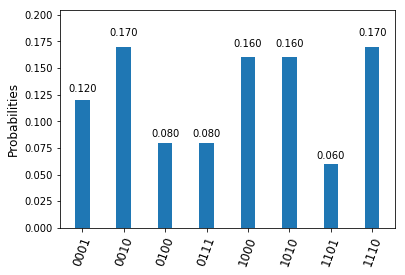

In [6]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.measure(qr, cr)
job = execute(qc_1 , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

Sending this curcit, that encodes a bit string, to the quantum chip gives us results how many times the specific state (encode as postion,value) was messured and finally the probability that it exists.

Eg. it was measured that state 0001 exists with probability 0.13. There is no 0000 state that means that this state did occure. That make us sure that on the position 000 in a bit string there should be 1. Anlogulsly on the posstion 001 there is 0. 

In real life, imperfections happen. So you could use the probability to resolve ambiguities: if you find both 0000 and 0001 in your results, accept the most probable and reject the other as noise.

We can decode the string from the states above, to check if we get it back from the quantum chip.


In [10]:
def decode_bitstring(counts):
    decoded_string = [ '' for _ in range(len(BS1)) ] # list with blank spaces for 8 bit values
    for string in counts: # loop over all 4 bit strings in result  
        pos = int(string[0:3], 2) # get integer that corresponds to first three bits
        decoded_string[pos] = string[3] # set the value of the decoded string at this position to the fouth bit
    decoded_string = ''.join(decoded_string) # turn list of 8 bit values into 8 bit string
    return decoded_string

bs1_decoded = decode_bitstring(st)
bs1_decoded

'10010010'

In [11]:
bs1_decoded == BS1

True

## BS1_inverted measure

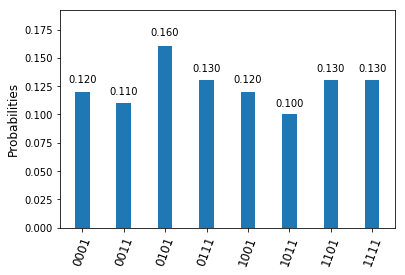

In [12]:
qc_1i = encode_bitstring(BS1, qr, cr, True)
qc_1i.measure(qr, cr)
job = execute(qc_1i , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

In [13]:
decode_bitstring(st)

'11111111'

**(??? 4)**

Why the inverted string consist only with 1? I've exptected it to be: 10010010 > 01101101

## Comparing the BS1 with BS1_inverted

Let's denote $|BS1>$ as the superpostion state created by the `encode_bitstring(BS1, ...)` and $ |BS1_i> $ as the superpostion state created by the `encode_bitstring(BS1, ..., inverse=True)`. This states are orthogonal if:
$$ <BS1|>BS1_i> = 0 $$

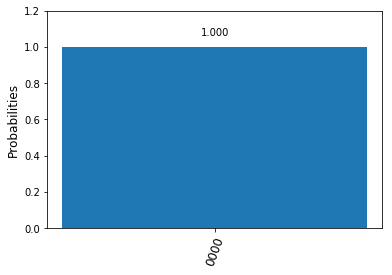

In [7]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.barrier(qr)
qc_1i = encode_bitstring(BS1, qr, cr, True)
qc_1i.measure(qr, cr)
qc_comb = qc_1 + qc_1i
job = execute(qc_comb , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

The initial state of any circuit is represented by `0` for all it's qubits. So in our case `0000` is the initial state of the circut - all the qubits are `0`, so far no position is set (for the first three qubits, and no data is set for the last qubit). In the initial state of the circut we dont interpreted the `0000` as the `0` bit on the first postion of the bit string.

Analising the quantum algorithm step by step:

1. We start with the initial state of the circut `0000`.
2. We initialize the circut with the BS1 string. Now the state of the circut represents the bit string.
3. We input the inverted bitstring and in the effect we get the circut back to the initial state which is `0000`. No other states where counted.


**TODO**

Explain the barrier gate.

## Comparing the BS1 with BS2_inverted

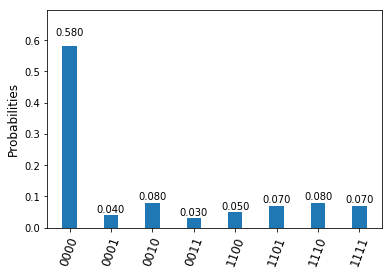

In [9]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.barrier(qr)
qc_2i = encode_bitstring(BS2, qr, cr, True)
qc_2i.measure(qr, cr)
qc_comb = qc_1 + qc_2i
job = execute(qc_comb , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

Let's denote $ |BS1> $ as the superpostion state created by the `encode_bitstring(BS1, ...)` and $ |BS2> $ as the 
**(??? 3)**

By looking only on state 0000 we get information how simmilar are the two bitstrings. (but why only 0000 state?)